In [2]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional

In [3]:
import numpy as np
import pandas as pd

x = np.load(f'/datasets/nicolas_facchinetti/processed_data/emodb/x_aug.npy')
y = np.load(f'/datasets/nicolas_facchinetti/processed_data/emodb/y_aug.npy')
metadata = pd.read_csv(f'/datasets/nicolas_facchinetti/processed_data/emodb/metadata_aug.csv')


In [12]:
metadata.head()

,path,filename,chunk,label,actor,gender,mod
0,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,0
1,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,1,sad,13,f,0
2,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,1
3,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,1,sad,13,f,1
4,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,1


In [14]:
metadata.iloc[[1]]

,path,filename,chunk,label,actor,gender,mod
1,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,1,sad,13,f,0


In [11]:
len(list(np.reshape(x[0], (16,16,256,3))))

16

In [20]:
x_div = []
y_div = []
md_div = []
for i in range(len(metadata)):
    X = list(np.reshape(x[i], (16,16,256,3)))
    Y = [y[i] for _ in range(16)]
    df = metadata.iloc[i]
    md = [(df["actor"], df["label"]) for _ in range(16)]
    x_div += X
    y_div += Y
    md_div += md


In [21]:
len(x_div), len(x), len(x)*16

(98912, 6182, 98912)

In [30]:
md_div_df = pd.DataFrame(md_div, columns=['actor', 'label'])
md_div_df

,actor,label
0,13,sad
1,13,sad
2,13,sad
3,13,sad
4,13,sad
...,...,...
98907,8,happy
98908,8,happy
98909,8,happy
98910,8,happy


In [33]:
y_div = np.array(y_div)
x_div = np.array(x_div)

In [24]:
def leave_one_speaker_out(data, n=5):
    speakers = data.actor.unique()
    # random select n actors as test
    selected = np.random.choice(speakers, size=n, replace=False)
    
    myCViterator = []
    for i in selected:
        # take all but not actor i data
        trainIndices = data[~(data['actor']==i)].index.values.astype(int)
        # take only original samples
        testIndices =  data[(data['actor']==i)].index.values.astype(int)
        
        np.random.shuffle(trainIndices)
        np.random.shuffle(testIndices)
        myCViterator.append((trainIndices, testIndices))
    return myCViterator

In [25]:
import matplotlib.pyplot as plt

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()

In [26]:
def train_avaluate(model_fn, kf, x, y):
    cv_acc = []
    for train_index, val_index in kf:
        m = model_fn()
        m.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
        # fit & predict
        history = m.fit(x[train_index], y[train_index],
                        batch_size=64,
                        epochs=30,
                        validation_data=(x[val_index], y[val_index]),
                        verbose=1)
        print("Done")
        cv_acc.append(history)
    return cv_acc

# Models

In [28]:
def get_m1():
    m = Sequential([
            InputLayer(input_shape=(16,256,3)),
            Conv2D(16, kernel_size=(3,3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2,2), strides=2),

            Conv2D(32, kernel_size=(3,3), activation='relu'),
            MaxPooling2D(pool_size=(2,2), strides=1),

            Conv2D(64, kernel_size=(3,3), activation='relu'),
            MaxPooling2D(pool_size=(2,2), strides=1),
            Flatten(),
            
            Dense(7, activation='softmax')
    ])
    return m

get_m1().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 254, 16)       448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 254, 16)       64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 127, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 125, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 124, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 122, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 121, 64)       

2022-11-22 16:33:13.558215: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-22 16:33:13.559172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2022-11-22 16:33:13.559233: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-22 16:33:13.559282: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-22 16:33:13.559300: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-11-22 16:33:13.559317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022

In [31]:
kf = leave_one_speaker_out(md_div_df, n=3)

In [36]:
t1 = train_avaluate(get_m1, kf, x_div, y_div)

2022-11-22 16:35:18.590794: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4437835776 exceeds 10% of free system memory.
2022-11-22 16:35:21.021025: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-22 16:35:21.036094: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3301490000 Hz


Epoch 1/30


2022-11-22 16:35:21.331066: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-22 16:35:21.521976: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1411/1411 [==============================] - 11s 6ms/step - loss: 1.3678 - accuracy: 0.4704 - val_loss: 1.3937 - val_accuracy: 0.4643
Epoch 2/30
1411/1411 [==============================] - 8s 6ms/step - loss: 1.0622 - accuracy: 0.5910 - val_loss: 1.3972 - val_accuracy: 0.4740
Epoch 3/30
1411/1411 [==============================] - 9s 6ms/step - loss: 0.9448 - accuracy: 0.6409 - val_loss: 1.3664 - val_accuracy: 0.4906
Epoch 4/30
1411/1411 [==============================] - 12s 9ms/step - loss: 0.8759 - accuracy: 0.6718 - val_loss: 1.5530 - val_accuracy: 0.4354
Epoch 5/30
1411/1411 [==============================] - 9s 6ms/step - loss: 0.8220 - accuracy: 0.6906 - val_loss: 1.5318 - val_accuracy: 0.4628
Epoch 6/30
1411/1411 [==============================] - 8s 6ms/step - loss: 0.7783 - accuracy: 0.7106 - val_loss: 1.4879 - val_accuracy: 0.4758
Epoch 7/30
1411/1411 [==============================] - 8s 6ms/step - loss: 0.7493 - accuracy: 0.7190 - val_loss: 1.6384 - val_accuracy: 0.4427
E

2022-11-22 16:39:41.876852: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4341891072 exceeds 10% of free system memory.


Epoch 1/30
1381/1381 [==============================] - 11s 8ms/step - loss: 1.3461 - accuracy: 0.4863 - val_loss: 1.4652 - val_accuracy: 0.4310
Epoch 2/30
1381/1381 [==============================] - 8s 6ms/step - loss: 1.0332 - accuracy: 0.6066 - val_loss: 1.4557 - val_accuracy: 0.4593
Epoch 3/30
1381/1381 [==============================] - 8s 6ms/step - loss: 0.9386 - accuracy: 0.6446 - val_loss: 1.5700 - val_accuracy: 0.4296
Epoch 4/30
1381/1381 [==============================] - 8s 6ms/step - loss: 0.8678 - accuracy: 0.6747 - val_loss: 1.5925 - val_accuracy: 0.4383
Epoch 5/30
1381/1381 [==============================] - 9s 6ms/step - loss: 0.8069 - accuracy: 0.6983 - val_loss: 1.6589 - val_accuracy: 0.4401
Epoch 6/30
1381/1381 [==============================] - 8s 6ms/step - loss: 0.7741 - accuracy: 0.7109 - val_loss: 1.6997 - val_accuracy: 0.4453
Epoch 7/30
1381/1381 [==============================] - 8s 6ms/step - loss: 0.7395 - accuracy: 0.7234 - val_loss: 1.7428 - val_accuracy

2022-11-22 16:43:59.473145: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4172808192 exceeds 10% of free system memory.


Epoch 1/30
1327/1327 [==============================] - 9s 7ms/step - loss: 1.3390 - accuracy: 0.4895 - val_loss: 2.1065 - val_accuracy: 0.3421
Epoch 2/30
1327/1327 [==============================] - 9s 7ms/step - loss: 1.0214 - accuracy: 0.6098 - val_loss: 1.9810 - val_accuracy: 0.3843
Epoch 3/30
1327/1327 [==============================] - 8s 6ms/step - loss: 0.9149 - accuracy: 0.6534 - val_loss: 2.0623 - val_accuracy: 0.3904
Epoch 4/30
1327/1327 [==============================] - 8s 6ms/step - loss: 0.8467 - accuracy: 0.6800 - val_loss: 2.0110 - val_accuracy: 0.4157
Epoch 5/30
1327/1327 [==============================] - 8s 6ms/step - loss: 0.7994 - accuracy: 0.6986 - val_loss: 2.2007 - val_accuracy: 0.3759
Epoch 6/30
1327/1327 [==============================] - 8s 6ms/step - loss: 0.7521 - accuracy: 0.7202 - val_loss: 2.3241 - val_accuracy: 0.3704
Epoch 7/30
1327/1327 [==============================] - 8s 6ms/step - loss: 0.7223 - accuracy: 0.7273 - val_loss: 2.7353 - val_accuracy:

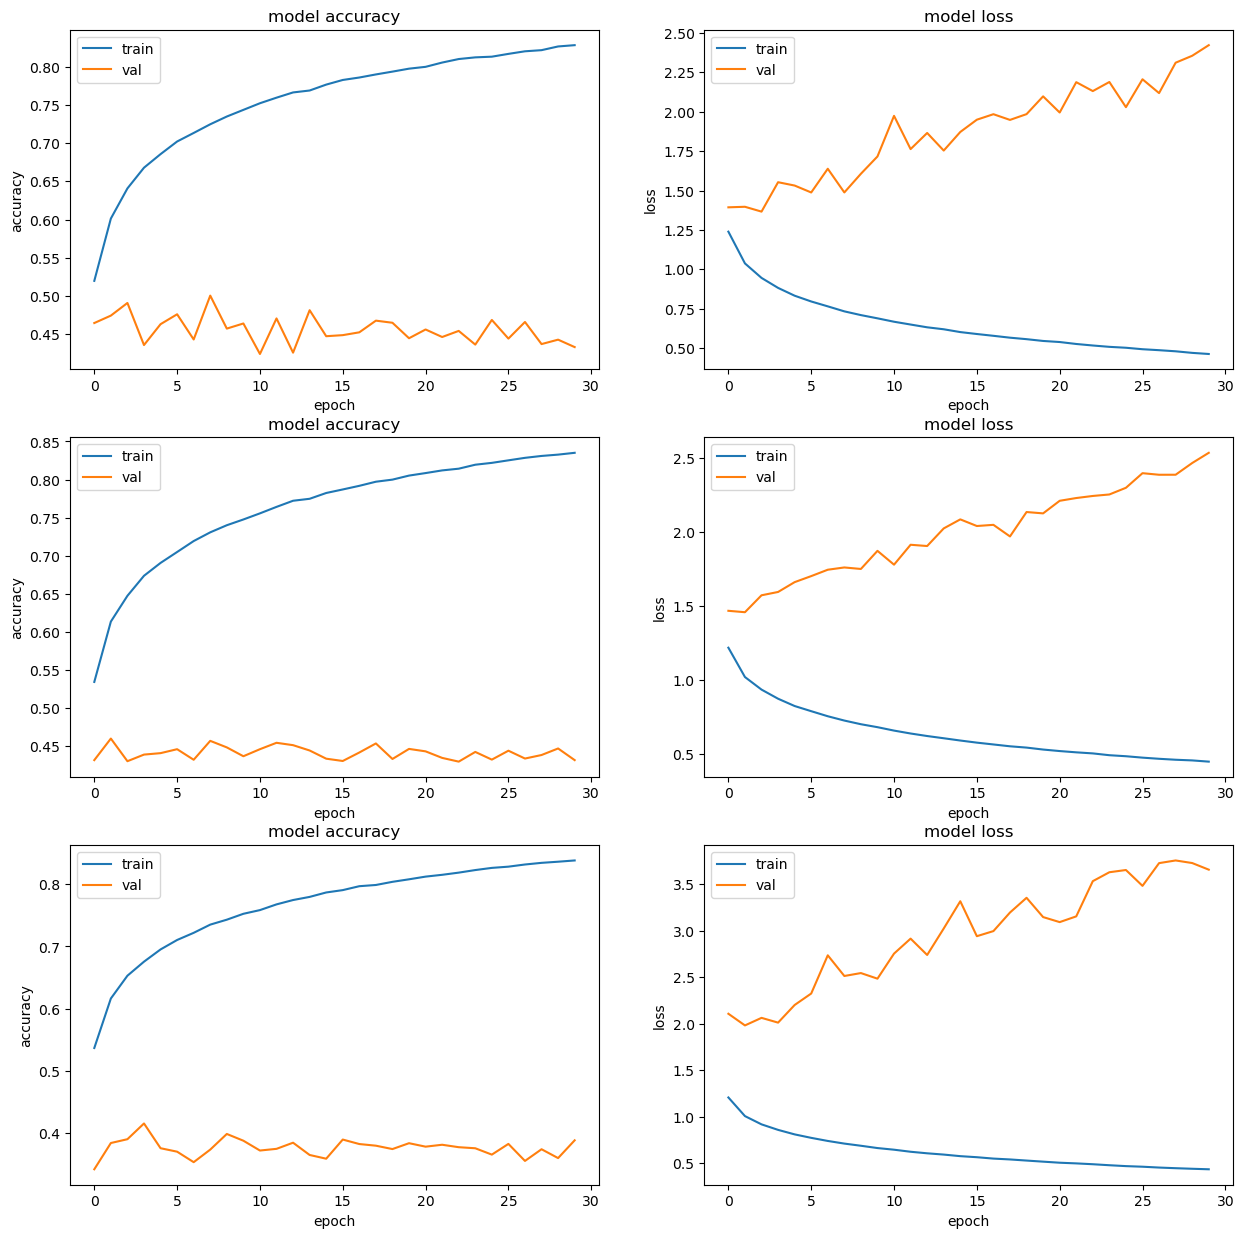

In [37]:
plot_stats(t1)